In [49]:
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split, GridSearchCV, \
    RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_transformers import *
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exercise 

Try a Support Vector Machine regressor ( sklearn.svm.SVR ), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [2]:
# load the housing dataset
housing = pd.read_csv('data/housing.csv', header=0, na_values=np.nan)
housing.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY

### Fill Missing Values

In [3]:
# checking dataset information
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


It seems we have missing data in ['total_bedrooms'] column

In [33]:
# print a few lines where NaN values are present
housing[housing.isna().any(axis=1)].head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
290    -122.16     37.77                47.0       1256.0             NaN   
341    -122.17     37.75                38.0        992.0             NaN   
538    -122.28     37.78                29.0       5154.0             NaN   
563    -122.24     37.75                45.0        891.0             NaN   
696    -122.10     37.69                41.0        746.0             NaN   

     population  households  median_income  median_house_value ocean_proximity  
290       570.0       218.0         4.3750            161900.0        NEAR BAY  
341       732.0       259.0         1.6196             85100.0        NEAR BAY  
538      3741.0      1273.0         2.5762            173400.0        NEAR BAY  
563       384.0       146.0         4.9489            247100.0        NEAR BAY  
696       387.0       161.0         3.9063            178400.0        NEAR BAY

In [48]:
# we can imbute the missing values. we must drop least feature
# since it's type object
housing_num = housing.drop('ocean_proximity', axis='columns')

imputer = SimpleImputer(strategy='median').fit(housing_num)
X_imped = imputer.transform(housing_num)

median = housing.total_bedrooms.median()
housing.total_bedrooms.fillna(median, inplace=True)

### EDA

In [93]:
housing.head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY

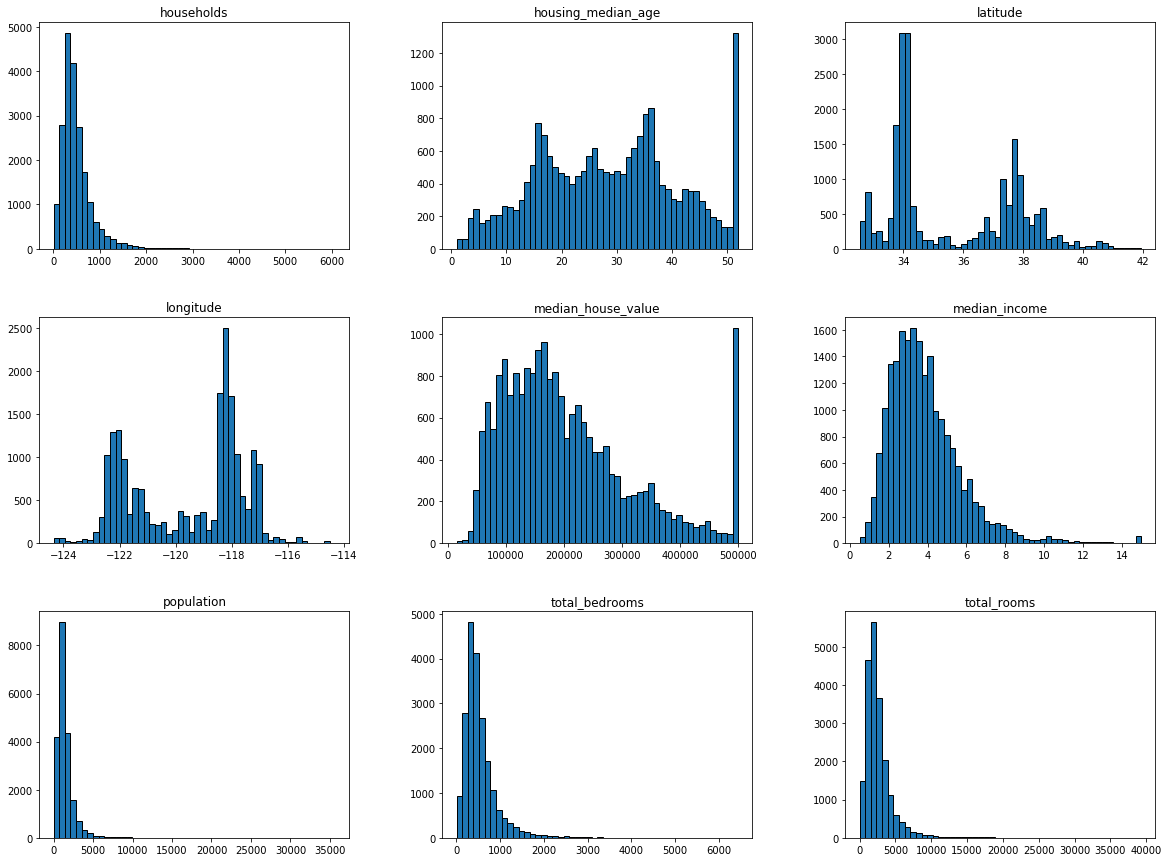

In [96]:
housing.hist(bins=50, figsize=(20,15), edgecolor='k', grid=False)
plt.show()

**median_income**:
* this feature is pre-scaled and thresholded with [0.5:15] as seen on x-axis. This is probably done to eliminate outliers in the data


**median_house_income**:
* target variable
* values also capped
* big count peak at 500k
* we want to ensure that training and test set have both proportionally all house values represented. For that we need convert this continuous feature into categorical feature

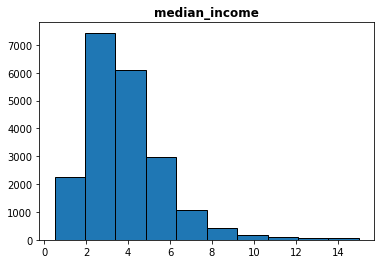

In [105]:
# lets inspect the median_house_value feature with fewer bins
housing.median_income.hist(edgecolor='k', grid=False)
plt.title('median_income', weight='bold')
plt.show()

* categorization into 10 classes is not practical since the distribution has a trailing tail
* lets convert incomes into 5 categories [0;1.5;3;4.5;6;infinity], where last class has bigger spawn but it has also proportionally less counts

In [106]:
# use pd.cut() to segment or re-bin data
housing['income_cat'] = pd.cut(x=housing['median_income'],
                               bins=[0.,1.5,3.0,4.5,6.0, np.inf],
                               labels=[1,2,3,4,5])
housing.income_cat.value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

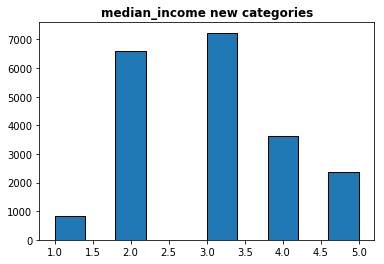

In [110]:
housing.income_cat.hist(grid=False, edgecolor='k')
plt.title('median_income new categories', weight='bold')
plt.show()

### Impute Categorical Data
Feature "ocean_proximity" is string type, lets inspect it's values

In [35]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

This feature is categorical and needs to be dummified

In [39]:
dummifyer = OneHotEncoder().fit(housing[['ocean_proximity']])
dummifyer.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
X_oprox_dummified = dummifyer.transform(housing[['ocean_proximity']])

# first 3 entries are labeled correctly as 'NEAR BAY'
X_oprox_dummified[:3, :].toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

### Feature Engineering

* each row in a dataset holds information about a district with multiple houses
* since the data is per district the columns "total_rooms", "total_bedrooms", "population" are not informative enouh
* we need to construct these features into per houshold, since we know the number of households per district

In [49]:
households = housing.households

housing['rooms_per_household'] = housing.total_rooms / households
housing['bedrooms_per_room'] = housing.total_bedrooms / households
housing['population_per_household'] = housing.population / households

In [50]:
# lets examine how these features now
# correlate with median_house_value
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049457
population_per_household   -0.023737
population                 -0.024650
bedrooms_per_room          -0.045637
longitude                  -0.045967
latitude                   -0.144160
Name: median_house_value, dtype: float64

* most interesting features are:
    * median_income
    * roooms_per_household
    * latitude
    * total_rooms
* lets inspect the dataset some more

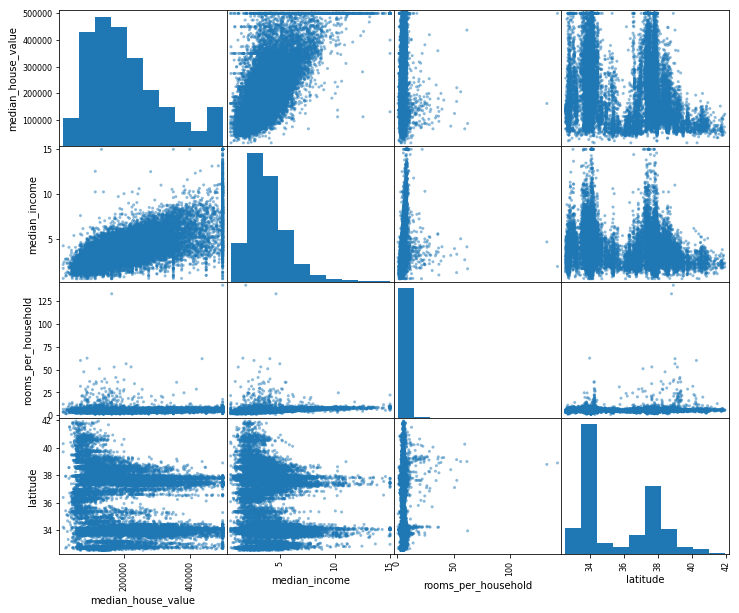

In [56]:
features = ['median_house_value','median_income', 'rooms_per_household', 'latitude']

pd.plotting.scatter_matrix(housing[features], figsize=(12,10), grid=True)
plt.show()

### Scaling / Standardizing Data

In [7]:
housing_new.describe()

longitude      latitude  housing_median_age    population  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   1425.476744   
std        2.003532      2.135952           12.585558   1132.462122   
min     -124.350000     32.540000            1.000000      3.000000   
25%     -121.800000     33.930000           18.000000    787.000000   
50%     -118.490000     34.260000           29.000000   1166.000000   
75%     -118.010000     37.710000           37.000000   1725.000000   
max     -114.310000     41.950000           52.000000  35682.000000   

         households  median_income  median_house_value  rooms_per_household  \
count  20640.000000   20640.000000        20640.000000         20640.000000   
mean     499.539680       3.870671       206855.816909             5.429000   
std      382.329753       1.899822       115395.615874             2.474173   
min        1.000000       0.499900        14999.000000             0.846154   
25%      280.000000       2.563400       119600.000000             4.440716   
50%      409.000000       3.534800       179700.000000             5.229129   
75%      605.000000       4.743250       264725.000000             6.052381   
max     6082.000000      15.000100       500001.000000           141.909091   

       bedrooms_per_room  population_per_household  
count       20640.000000              20640.000000  
mean            1.100910                  3.070655  
std             0.519159                 10.386050  
min             0.121204                  0.692308  
25%             1.005525                  2.429741  
50%             1.048860                  2.818116  
75%             1.100015                  3.282261  
max            34.066667               1243.333333

The data needs to be standardized, since some features vary quite a bit
We subtract the means from each data point and divide it by its variance

In [65]:
num_features = housing.drop('ocean_proximity', axis='columns')

scaler = StandardScaler().fit(num_features.values)
X_scaled = scaler.transform(num_features)

housing_scaled_df = pd.DataFrame(data=X_scaled, columns=list(num_features.columns))
housing_scaled_df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  2.064000e+04  2.064000e+04        2.064000e+04  2.064000e+04   
mean  -6.527810e-15  1.256263e-15        8.557001e-16  1.475181e-16   
std    1.000024e+00  1.000024e+00        1.000024e+00  1.000024e+00   
min   -2.385992e+00 -1.447568e+00       -2.196180e+00 -1.207283e+00   
25%   -1.113209e+00 -7.967887e-01       -8.453931e-01 -5.445698e-01   
50%    5.389137e-01 -6.422871e-01        2.864572e-02 -2.332104e-01   
75%    7.784964e-01  9.729566e-01        6.643103e-01  2.348028e-01   
max    2.625280e+00  2.958068e+00        1.856182e+00  1.681558e+01   

       total_bedrooms    population    households  median_income  \
count    2.043300e+04  2.064000e+04  2.064000e+04   2.064000e+04   
mean     2.035816e-16 -6.465442e-17  2.139358e-16   3.734255e-16   
std      1.000024e+00  1.000024e+00  1.000024e+00   1.000024e+00   
min     -1.274093e+00 -1.256123e+00 -1.303984e+00  -1.774299e+00   
25%     -5.740034e-01 -5.638089e-01 -5.742294e-01  -6.881186e-01   
50%     -2.441308e-01 -2.291318e-01 -2.368162e-01  -1.767951e-01   
75%      2.589843e-01  2.644949e-01  2.758427e-01   4.593063e-01   
max      1.401871e+01  3.025033e+01  1.460152e+01   5.858286e+00   

       median_house_value  
count        2.064000e+04  
mean         8.950635e-16  
std          1.000024e+00  
min         -1.662641e+00  
25%         -7.561633e-01  
50%         -2.353337e-01  
75%          5.014973e-01  
max          2.540411e+00

### Pipeline

* ideally we'd like to perform everything in a pipeline and not in separate steps
* since transformers in sklearn are limited we have to make our own transformers:
    * we create one for selecting specific features from a dataframe
    * we create one for feature engineering before scaling
* we need to create class with 3 methods: fit, trasnform, and fit_transform()

In [187]:
housing = pd.read_csv('data/housing.csv', header=0, na_values=np.nan)
housing.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY

In [188]:
y = housing['median_house_value'].values
housing = housing.drop('median_house_value', axis='columns')

In [189]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [134]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class FeatureCombiner(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_house = X[:, rooms_ix] / X[:, households_ix]
        population_per_house = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_rooms = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_house, population_per_house, bedrooms_per_rooms]

Demonstrate how the results of the FeatureCombiner estimator:

In [122]:
housing_extra_vals = FeatureCombiner().transform(housing.values)
housing_extra_df = pd.DataFrame(data=housing_extra_vals, 
                                columns=list(housing.columns) + ['rooms_per_house',
                                                           'population_per_house',
                                                           'bedrooms_per_room'])
housing_extra_df.head(2)

longitude latitude housing_median_age total_rooms total_bedrooms population  \
0   -122.23    37.88                 41         880            129        322   
1   -122.22    37.86                 21        7099           1106       2401   

  households median_income median_house_value ocean_proximity rooms_per_house  \
0        126        8.3252             452600        NEAR BAY         6.98413   
1       1138        8.3014             358500        NEAR BAY         6.23814   

  population_per_house bedrooms_per_room  
0              2.55556          0.146591  
1              2.10984          0.155797

#### Construct Pipeline

Pipeline checklist:
1. Fill missing values in "total_bedrooms" column
2. Combine features: 
    * "total_rooms" --> "rooms_per_house"
    * "population" --> "population_per_house"
    * "total_bedrooms" --> "bedrooms_per_rooms"
3. Standardize numeric features, as well as our target feature
4. Dummify "ocean_proximity" feature

In [154]:
housing.shape

(20640, 9)

In [155]:
num_features = housing.drop(['ocean_proximity'], axis='columns')
cat_features = 'ocean_proximity'

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('combiner', FeatureCombiner()),
    ('std_scaler', StandardScaler())])

# "ocean_proximity" feature needs to be dummified, we use
# ColumnTransformer class that links these two steps for
# numeric data and categorical data. Thus these features 
# have to be specified explicitly
full_pipe = ColumnTransformer([
    ("numeric", num_pipe, list(num_features)),
    ('categorical', OneHotEncoder(), [cat_features])])

X_prepared = full_pipe.fit_transform(housing)

In [156]:
X_prepared.shape

(20640, 16)

Create stratter array. This divides training and testing sets proportionally based on income classes.

In [157]:
stratter = pd.cut(x=housing['median_income'],
                  bins=[0.,1.5,3.0,4.5,6.0,np.inf], 
                  labels=[1,2,3,4,5])
stratter.values.shape

(20640,)

Apply SVR to our data:

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, stratify=stratter.values,
                                                    random_state=0)

param_grid = [{'kernel': ['linear'], 'C': np.logspace(5, 6, 4)},
              {'kernel': ['rbf'], 'C': np.logspace(5,6, 4),
               'gamma': np.logspace(-2, 1, 4)}]

grid = GridSearchCV(SVR(), param_grid, n_jobs=-1, iid=False, cv=5,
                   return_train_score=False).fit(X_train, y_train)

In [159]:
print('Best cv validation score: {:.3f}'.format(grid.best_score_))
print('Best cv parameters: {}'.format(grid.best_params_))
print('Generalization score: {:.3f}'.format(grid.score(X_test, y_test)))

Best cv validation score: 0.777
Best cv parameters: {'C': 1000000.0, 'gamma': 0.1, 'kernel': 'rbf'}
Generalization score: 0.776


## Exercise 

Try replacing GridSearchCV with RandomizedSearchCV .

In [160]:
param_grid = {'kernel': ['rbf'], 
              'C': np.logspace(6, 7, 4),
              'gamma': np.logspace(-1.5, -0.5, 4)}

grid = RandomizedSearchCV(SVR(), param_grid, n_jobs=-1, iid=False, cv=5,
                          return_train_score=False).fit(X_train, y_train)

print('Best cv validation score: {:.3f}'.format(grid.best_score_))
print('Best cv parameters: {}'.format(grid.best_params_))
print('Generalization score: {:.3f}'.format(grid.score(X_test, y_test)))

KeyboardInterrupt: 

## Exercise

Try adding a transformer in the preparation pipeline to select only the most important attributes.

* First we need to find feature importances
* We use `RandomForestRegressor`, since we have a regression task
* NB! Decision tree models do not need data normalization!

In [174]:
housing.head(1)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   

   population  households  median_income ocean_proximity  
0       322.0       126.0         8.3252        NEAR BAY

In [191]:
# lets prepare the data again
num_features = housing.drop('ocean_proximity', axis='columns')
cat_features = housing['ocean_proximity']

num_prep_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('combiner', FeatureCombiner())])

col_prep_pipe = ColumnTransformer([
    ('numeric', num_prep_pipe, list(num_features)),
    ('categorical', OneHotEncoder(), ['ocean_proximity'])])

X_prepped = col_prep_pipe.fit_transform(housing)

In [192]:
stratter = pd.cut(x=housing['median_income'],
                  bins=[0.,1.5,3.0,4.5,6.0,np.inf], 
                  labels=[1,2,3,4,5])

X_prepped.shape, stratter.shape

((20640, 16), (20640,))

In [208]:
num_features.shape

(20640, 8)

In [199]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X_prepped, y, 
    stratify=stratter.values, random_state=0)

In [201]:
X_train.shape, y_train.shape

((15480, 16), (15480,))

In [202]:
forest_reg = RandomForestRegressor()

param_grid = {'n_estimators': np.array([30, 50, 70]),
              'max_features': np.array([4, 6, 8])}

grid = GridSearchCV(forest_reg, param_grid, cv=5, iid=False,
                   return_train_score=False, n_jobs=-1).fit(X_train, y_train)

In [205]:
print('Best cv score: {:.3f}'.format(grid.best_score_))
print('Best RandomForestRegressor parameters: {}'.format(grid.best_params_))
print('Feature importances:\n{}'. format(grid.best_estimator_.feature_importances_))

Best cv score: 0.817
Best RandomForestRegressor parameters: {'max_features': 6, 'n_estimators': 70}
Feature importances:
[7.53799733e-02 6.65746083e-02 4.11454027e-02 1.70492923e-02
 1.69098884e-02 1.73191836e-02 1.62155328e-02 3.18223370e-01
 5.31085489e-02 1.05876029e-01 9.77155910e-02 1.28741851e-02
 1.52962694e-01 1.95809229e-04 2.90844306e-03 5.54144912e-03]


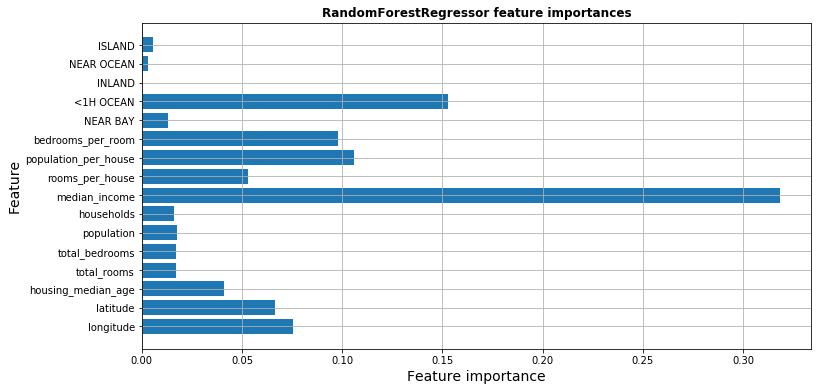

In [225]:
# plotting the imortances
y_labels = list(num_features) + ['rooms_per_house', 'population_per_house', 'bedrooms_per_room'] + \
    list(housing.ocean_proximity.unique())
n_features = X_train.shape[1]

plt.figure(figsize=(12, 6))
plt.barh(y=range(n_features), 
         width=grid.best_estimator_.feature_importances_,
         align='center')
plt.grid(True)
plt.yticks(ticks=range(X_train.shape[1]), labels=y_labels)
plt.xlabel('Feature importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('RandomForestRegressor feature importances', weight='bold')
plt.show()

In [239]:
# lets create the transforer
class TopFeaturesSelector(BaseEstimator, TransformerMixin):
    """Returns k top features, based on feature importances array.
        Parameters:
            feature_importnaces [arr]
            k [int] - number of top features"""
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.top_f_indices_ = np.argsort(self.feature_importances)[::-1][:k]
        return self
    def transform(self, X):
        return X[:, self.top_f_indices_]

In [245]:
rforestreg_f_imps = grid.best_estimator_.feature_importances_

num_pipe = make_pipeline(SimpleImputer(),
                         FeatureCombiner(),
                         StandardScaler())

num_cat_pipe = ColumnTransformer([
    ('num_pipe', num_pipe, list(num_features)),
    ('cat_pipe', OneHotEncoder(), ['ocean_proximity'])
])

top_f_full_pipe = make_pipeline(num_cat_pipe,
                                TopFeaturesSelector(rforestreg_f_imps, k=5))
X_prepped_top_5_features = top_f_full_pipe.fit_transform(housing)

In [246]:
X_prepped_top_5_features.shape

(20640, 4)

## Exercise

Try creating a single pipeline that does the full data preparation plus the final prediction.

In [248]:
# read in raw data
housing = pd.read_csv('data/housing.csv', header=0, na_values=np.nan)
housing.head(1)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY

In [249]:
# extrct target value
y = housing.median_house_value.values

# drop target from the feature list
housing = housing.drop('median_house_value', axis='columns')
housing.head(1)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   

   population  households  median_income ocean_proximity  
0       322.0       126.0         8.3252        NEAR BAY

In [250]:
# separate numerical and categorical features
numeric_f_df = housing.drop('ocean_proximity', axis='columns')
categorical_f_df = housing.ocean_proximity

In [260]:
# determine feature importances
num_prep_pipe = make_pipeline(SimpleImputer(),
                           FeatureCombiner(),
                           StandardScaler())

full_prep_pipe = ColumnTransformer([
    ('num_features', num_f_pipe, list(numeric_f_df)),
    ('cat_features', OneHotEncoder(), ['ocean_proximity'])])

f_importance_full_pipe = make_pipeline(num_cat_f_combined_pipe,
                                       RandomForestRegressor(n_estimators=100, 
                                                             max_features=6)).fit(housing, y)

feature_importances = f_importance_full_pipe.named_steps['randomforestregressor'].feature_importances_

In [254]:
f_importance_full_pipe.steps

[('columntransformer',
  ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
           transformer_weights=None,
           transformers=[('num_features', Pipeline(memory=None,
       steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
         verbose=0)), ('featurecombiner', FeatureCombiner())]), ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedroo... 'numpy.float64'>, handle_unknown='error',
         n_values=None, sparse=True), ['ocean_proximity'])])),
 ('randomforestregressor',
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_jobs=None, oob_score=False,
             random_state=None, verbose=0, warm_start=False))]

In [259]:
feature_importances = f_importance_full_pipe.named_steps['randomforestregressor'].feature_importances_

# SVC on housing

(from scratch!)

In [5]:
house = datasets.fetch_california_housing()

In [6]:
house.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [41]:
housing = pd.DataFrame(data=house.data, columns=house.feature_names)
housing.shape

(20640, 8)

In [10]:
housing.head(3)

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24

In [12]:
print(house.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [11]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
MedInc        20640 non-null float64
HouseAge      20640 non-null float64
AveRooms      20640 non-null float64
AveBedrms     20640 non-null float64
Population    20640 non-null float64
AveOccup      20640 non-null float64
Latitude      20640 non-null float64
Longitude     20640 non-null float64
dtypes: float64(8)
memory usage: 1.3 MB


In [14]:
housing.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741     33.930000   -121.800000  
50%        2.818116     34.260000   -118.490000  
75%        3.282261     37.710000   -118.010000  
max     1243.333333     41.950000   -114.310000

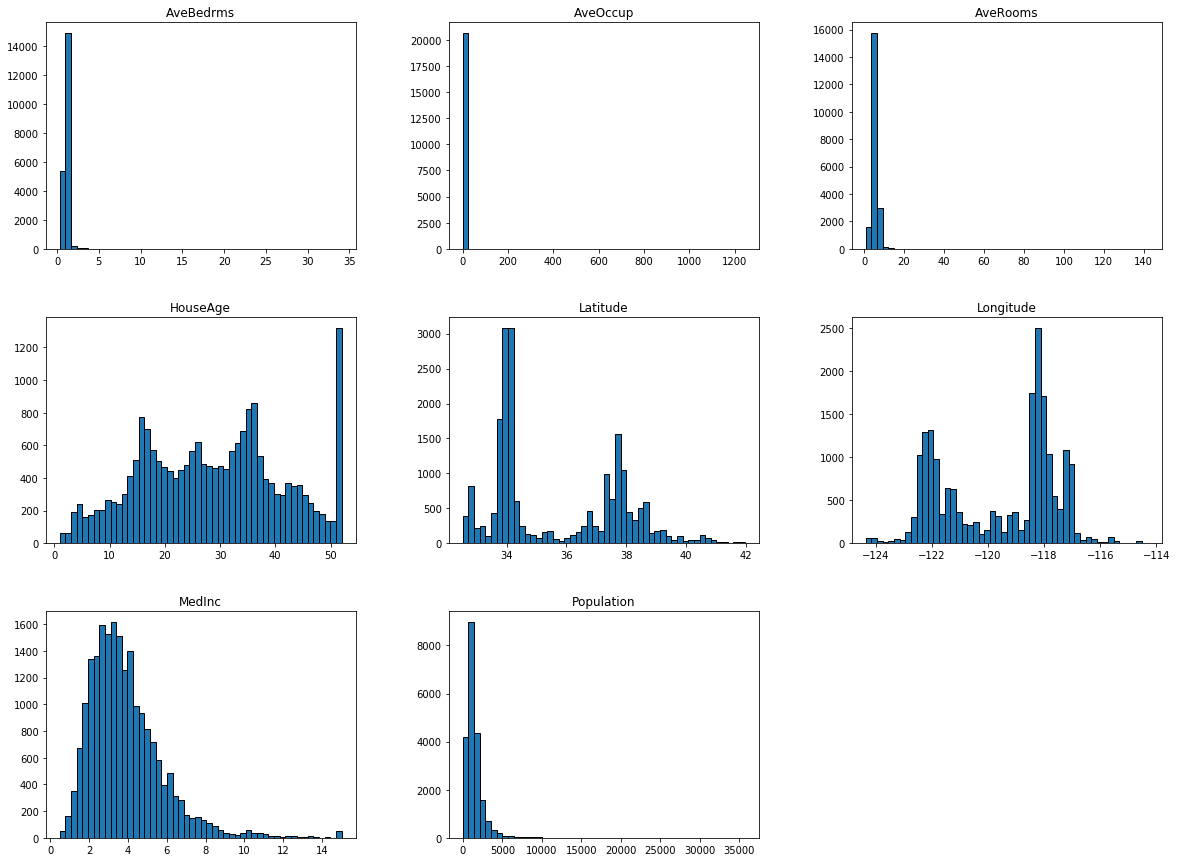

In [13]:
housing.hist(bins=50, figsize=(20,15), edgecolor='k', grid=False)
plt.show()

In [50]:
# data
X = house.data
y = house.target

# scale the data
X_scaled = StandardScaler().fit_transform(X)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)

linsvr_reg = LinearSVR()
param_grid = {'epsilon': np.linspace(0.5, 1, 10),
              'C': np.linspace(0.001, 0.05, 10)}

grid = GridSearchCV(linsvr_reg, param_grid, cv=3, iid=False,
                    return_train_score=False, n_jobs=-1).fit(X_train[:8000], y_train[:8000])

In [61]:
print('LinearSVR best parameters: {}'.format(grid.best_params_))
print('LinearSVR best score: {:.3f}'.format(grid.best_score_))

LinearSVR best parameters: {'C': 0.01188888888888889, 'epsilon': 0.8333333333333333}
LinearSVR best score: 0.582


In [68]:
linsvr_reg_best = SVR(gamma='auto').fit(X_train, y_train)

In [69]:
y_pred = linsvr_reg_best.predict(X_test)
print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE: 0.590
